# Working with grid data

In this notebook, we show some of the most useful features of the [grid_data](../grid_data.rst) module. 

There are three important objects in [grid_data](../grid_data.rst):
- `UniformGrid` represents Cartesian grids,
- `UniformGridData` represents data on `UniformGrid`,
- `HierarchicalGridData` represents data on multiple grids with different spacings (a mesh-refined grid).

In most cases you will not define these objects directly, but it is important to know how they work.
To learn how to read the simulation data, see [working with grid funcitons](cactus_grid_functions.ipynb).

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import grid_data as gd
from kuibit import grid_data_utils as gdu
from kuibit import series

%matplotlib inline

## `UniformGrid`

To generate data, we start from preparing a grid. `kuibit` follows the conventions in `Carpet` and identifies a grid with (1) the number of points along each direction, (2) the coordinate of left bottom cell, (3) the spacing or the coordinate of the top right cell.
In addition, `UniformGrid` can contain additional information, like the number of refinement level, or the time. These grids are always cell-centered.

Let us create a 2D grid: 

In [2]:
grid = gd.UniformGrid([201, 201], # Number of points
                      x0=[-100, -100], # origin
                      x1=[100, 100] # other corner
                      )

`UniformGrid` are meant to be immutable objects, and indeed there is not much that we can do with them. If we print them, we will find some interesting information.

In [3]:
print(grid)

Shape            = [201 201]
Num ghost zones  = [0 0]
Ref. level       = -1
Component        = -1
x0               = [-100. -100.]
x0/dx            = [-100. -100.]
x1               = [100. 100.]
x1/dx            = [100. 100.]
Volume           = 40401.0
dx               = [1. 1.]
Time             = None
Iteration        = None



We can obtain this (and other information) directly from `grid`, for example.

In [4]:
print(f"Unit volume {grid.dv}, number of dimensions {grid.num_dimensions}")

Unit volume 1.0, number of dimensions 2


`UniformGrid` objects can be indexed and support the `in` operator, which are quite convinent. 

In [5]:
print(f"The coordinate cooresponding to the index 1, 2 is {grid[1,2]}")
print(f"Is [-140, 50] in the grid?: {[-140, 50] in grid}")

The coordinate cooresponding to the index 1, 2 is [-99. -98.]
Is [-140, 50] in the grid?: False


Finally, one can get explicitly the coordinates with the `coordinates` method.
This can return arrays with the coordinates along each direction (default), or can return the coordinates as a numpy meshgrid 
(if `as_meshgrid=True`), or can return a list of arrays with the same shape of the grid and the values of the coordinates (if `as_same_shape=True`).
Let's see one example.

In [6]:
print(grid.coordinates()[0])

[-100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.  -92.  -91.  -90.  -89.
  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.  -80.  -79.  -78.  -77.
  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.  -68.  -67.  -66.  -65.
  -64.  -63.  -62.  -61.  -60.  -59.  -58.  -57.  -56.  -55.  -54.  -53.
  -52.  -51.  -50.  -49.  -48.  -47.  -46.  -45.  -44.  -43.  -42.  -41.
  -40.  -39.  -38.  -37.  -36.  -35.  -34.  -33.  -32.  -31.  -30.  -29.
  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.  -20.  -19.  -18.  -17.
  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.
   -4.   -3.   -2.   -1.    0.    1.    2.    3.    4.    5.    6.    7.
    8.    9.   10.   11.   12.   13.   14.   15.   16.   17.   18.   19.
   20.   21.   22.   23.   24.   25.   26.   27.   28.   29.   30.   31.
   32.   33.   34.   35.   36.   37.   38.   39.   40.   41.   42.   43.
   44.   45.   46.   47.   48.   49.   50.   51.   52.   53.   54.   55.
   56.   57.   58.   59.   60.   61.   62.   63.   

## `UniformGridData`

`UniformGridData` are much more interesting. `UniformGridData` packages a
`UniformGrid` and some data in the same object and provides many useful
functionalities.

Let us create some fake data to explore the capabilities. A simple way to
generate a `UniformGridData` from a function is with `sample_function`.

In [7]:
grid_data = gdu.sample_function(lambda x, y: x * y,
                          [101, 201], # shape
                          [0, 0], # origin
                          [10, 10] # other corner
                          )

We can visualize this data with matplotlib `contourf`. 
To do this, we need the coordinates as meshgrid, and we need the actual data.
To get the first, we use the `coordinates_meshgrid` method, for the second, we
access directly the data with the `data` attribute. This is stored as a numpy 
array. Often, we want to plot these objects. Using `data` directly would lead to 
transposing the actual physical quantity, because `data` is a matrix stored by rows, 
so, the first index does not label the x coordiante, but the y. 
We provide the aliaxs `data_xyz`, which is the the tranposed of `data`. This is ready to be plotted. 


⚠️ In this tutorial, we plot the various quantities directly. This is to understand to access the data and what is the fundamental structure of these objects. However, `kuibit` comes with plottings methods too. The `visualize_matplotlib` module contains multiple functions to make 2D plots. We touch upon this at the end of this tutorial.

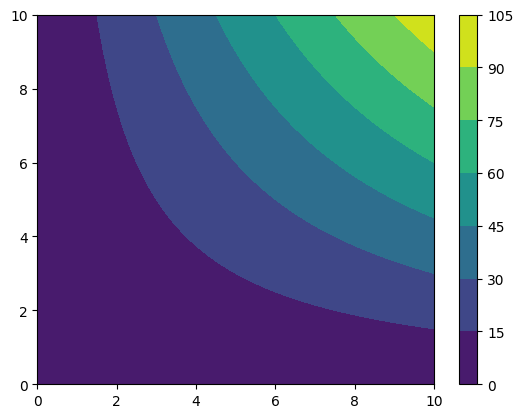

In [8]:
cf = plt.contourf(*grid_data.coordinates_meshgrid(), # The star is to unpack the list
                  grid_data.data_xyz) 
plt.colorbar(cf)

`UniformGridData` support all the mathematical operations we may want, for instance.

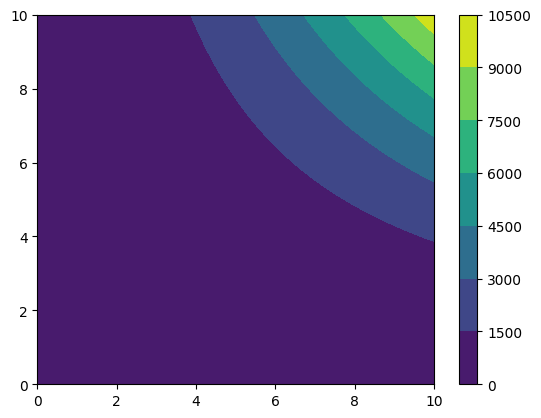

In [9]:
funky_data = np.sqrt(grid_data) + grid_data**2 * np.tanh(grid_data)
cf = plt.contourf(*funky_data.coordinates_meshgrid(), funky_data.data_xyz)
plt.colorbar(cf)

We can find the absolute maximum and where the coordinate where the absolute maximum is reached (the argument `absolute=False` would be required if we did not want the absolute).

In [10]:
print(f"The absolute maximum is {funky_data.abs_max()}")
print(f"The absolute maximum occurs at {funky_data.coordinates_at_maximum()}")

The absolute maximum is 10010.0
The absolute maximum occurs at [10. 10.]


`UniformGridData` can be interpolated with splines to evalute data everywhere, even where there was no data. With this, we can make `UniformGridData` callable objects:

In [11]:
print(f"The value of funky_data at (2, 3) is {funky_data((2,3)):.3f}")

The value of funky_data at (2, 3) is 38.449


`UniformGridData` have built-in a collection of useful functions, for example:

The mean of funky_data is 1123.865
The integral of funky_data is 114077.947
The norm2 of funky_data is 20417.836


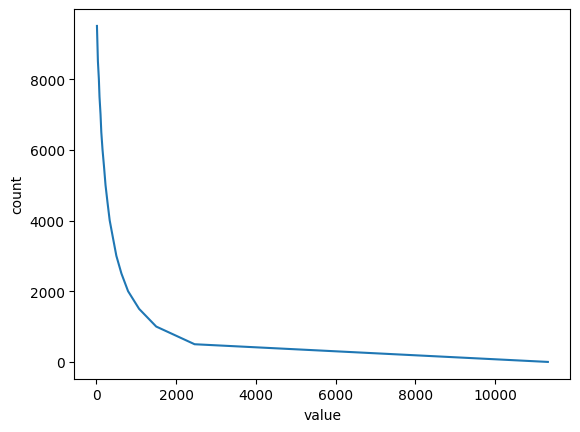

In [12]:
print(f"The mean of funky_data is {funky_data.mean():.3f}")
print(f"The integral of funky_data is {funky_data.integral():.3f}")
print(f"The norm2 of funky_data is {funky_data.norm2():.3f}")

bins, hist = funky_data.histogram(num_bins=20)
plt.ylabel("count")
plt.xlabel("value")
plt.plot(bins, hist[:-1])

It is not possible to combine directly two `UniformGridData` with different associated grids, 
but it is always possible to resample the objects so that they have a common grid.

Pay attention: resampling operations can be very expensive with large grids or high dimensions! 

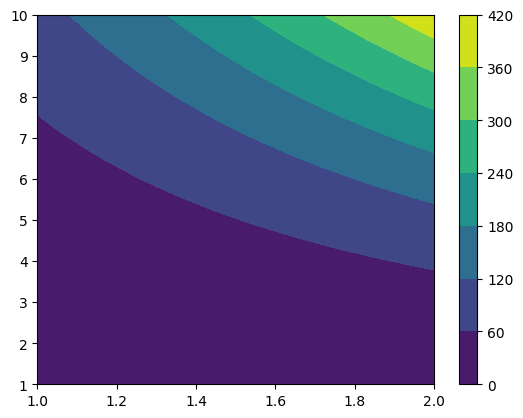

In [13]:
new_grid = gd.UniformGrid([201, 301], x0=[1, 1], x1=[2, 10])
resampled_funky = funky_data.resampled(new_grid)
cf = plt.contourf(*resampled_funky.coordinates_meshgrid(), resampled_funky.data_xyz)
plt.colorbar(cf)

Being able to resample `UniformGridData` means that even if it is not possible to directly
combine objects with different grids, you can always resample them to a common grid, and then
perform the operation.

Often, it is useful to save a `UniformGridData` to disk. A common example is to resampled 3D grid data
on a cluster and move the much smaller saved file to a local computer or laptop.

This can be achieved with the `save` method and the `load_UniformGridData` function.

In [14]:
resampled_funky.save("/tmp/funky.npz")

from kuibit.grid_data_utils import load_UniformGridData

loaded_data = load_UniformGridData("/tmp/funky.npz")

The fastest format to save data in is `npz`, but this is not always portable. 
The `save` method accepts many other formats, like `txt`, `dat`, and also compressed
ones (e.g., `txt.gz`).

## `HierarchicalGridData`

Now that we have some familiarity with `UniformGridData`, we can move to the most important
object, `HierarchicalGridData`. The relevance of this class is due to the fact that simulation
data is represented with `HierarchicalGridData` objects.

A `HierarchicalGridData` is a collection of `UniformGridData`, or (or more) for each refinement
level.

Let us prepare some fake data.

In [15]:
# 3 refinement levels
data = []
for ref_level in range(3):
    resolution = (1 + ref_level) * 20 + 1
    data.append(gdu.sample_function(lambda x, y: x*y + 5,
                                   [resolution, resolution],
                                   [-10, -10], 
                                   [10, 10],
                                   ref_level=ref_level
                                   ))
hg = gd.HierarchicalGridData(data)
print(hg)

Available refinement levels (components):
0 (1)
1 (1)
2 (1)
Spacing at coarsest level (0): [1. 1.]
Spacing at finest level (2): [0.33333333 0.33333333]


"Components" are essentially patches of grid. In some cases,
components are a result of running the code on multiple processes.
In this case, kuibit will try to merge them in a single grid.
In other instances, when there are multiple centers of refinement,
the components are real. Here, kuibit will do nothing and will
keep all the components around.

To access a specific refinement level, we can use the backet operator.
This will return a list of all the components at that level. Often,
there will be only one element because kuibit successfully merged
the various patches. In this case, one can use the `get_level` method
to get directly the data on that level.

In [16]:
level2 = hg.get_level(2)

In [17]:
type(level2)

kuibit.grid_data.UniformGridData

As we see, this is just a `UniformGridData`, so everything we can operate
on single levels exactly in the same way we work on `UniformGridData`.
If the  `HierarchicalGridData` has multiple disconnected components, 
`hg[2]` will instead return a list of `UniformGridData`.

 `HierarchicalGridData` fully support mathematical operations. (Binary operations
 are performed only if the two objects have the same grids and components.)

In [18]:
more_funk = (abs(hg) + 2).log() # For some reasons np.log(hg) doesn't work... 

# We can also call the HierarchicalGridData
print(f"more_funk of (2, 3) is {more_funk((2,3)):.3f}")

more_funk of (2, 3) is 2.565


We cannot plot directly this object, because it is a complicated object. To plot it, we have to merge the refinement levels to a single `UniformGridData`. We can do this with `refinement_levels_merged()`. 

Note that `refinement_levels_merged` is a very expensive operation and that it is provided only for small datasets or for one-dimensional data. 

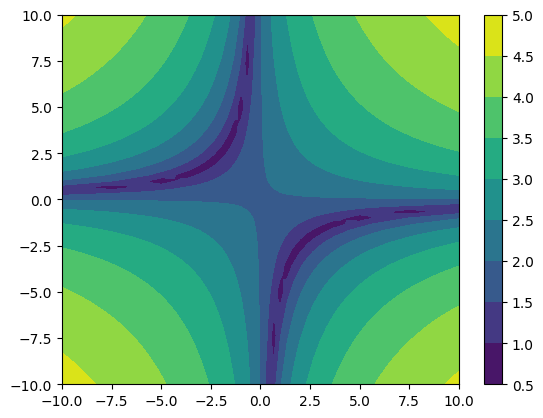

In [19]:
merged = more_funk.refinement_levels_merged(resample=True)
cf = plt.contourf(*merged.coordinates_meshgrid(), merged.data_xyz)
plt.colorbar(cf)

As you noticed, we enabled the `resample` option. With this option the coarser refinement levels are interpolated to the new finer grid using multilinear interpolation.

When working with large grids, many refinement levels, and/or 3D data, merging the various refinement levels can be a very expensive operation. However, often we don't need the entire grid, but we want to look at a portion. `HierachicalGridData` objects have a method to merge the refinement levels on a specified grid.

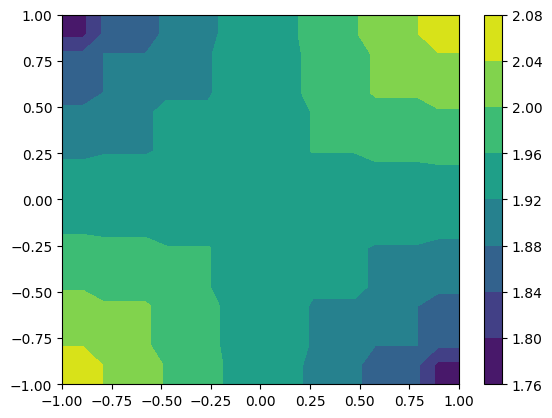

In [20]:
small_funk = more_funk.to_UniformGridData([20, 20], x0=[-1, -1], x1=[1, 1], resample=False)
cf = plt.contourf(*small_funk.coordinates_meshgrid(), small_funk.data_xyz)
plt.colorbar(cf)

`HierachicalGridData` objects have a lot of information that is accessible as a property.

In [21]:
print(f"Available refinement levels: {hg.refinement_levels}")
print(f"Spacing of the coarsest: {hg.coarsest_dx}")
print(f"Spacing of the finest: {hg.finest_dx}")
print(f"Finest level: {hg.finest_level}")

Available refinement levels: [0, 1, 2]
Spacing of the coarsest: [1. 1.]
Spacing of the finest: [0.33333333 0.33333333]
Finest level: <kuibit.grid_data.UniformGridData object at 0x7f3093d8f740>


Often, we want to look at a specific cut of the data. `UniformGridData` can be sliced easily. Just prepare a `cut` array with `None` where you want to keep the dimension, and the coordiante of where you want to slice. For example, here we extract the line with `y=0.7`.

Shape            = [20]
Num ghost zones  = [0]
Ref. level       = -1
Component        = -1
x0               = [-1.]
x0/dx            = [-9.5]
x1               = [1.]
x1/dx            = [9.5]
Volume           = 2.1052631578947367
dx               = [0.10526316]
Time             = None
Iteration        = None



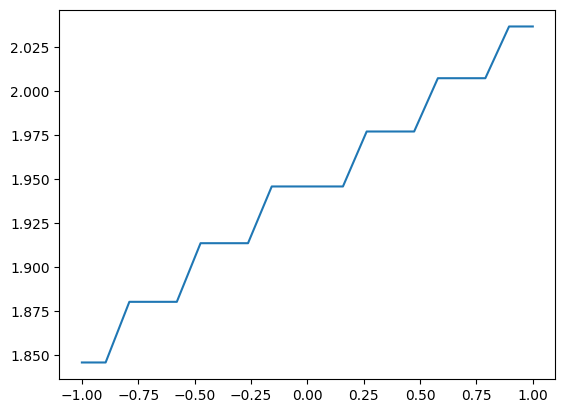

In [22]:
along_y = small_funk.sliced([None,0.7])
print(along_y.grid)
plt.plot(*along_y.coordinates_meshgrid(), along_y.data)

When working with a one-dimensional array, you can consider converting it to a `GridSeries` with the method `to_GridSeries`. That is: instead of using the entire infrastructure for grid data, you can use the infrastructure for series (e.g., `TimeSeries`). The main advantage is that the series infrastrcture is more direct and lean. For example, you can plot directly with `plt.plot()`.

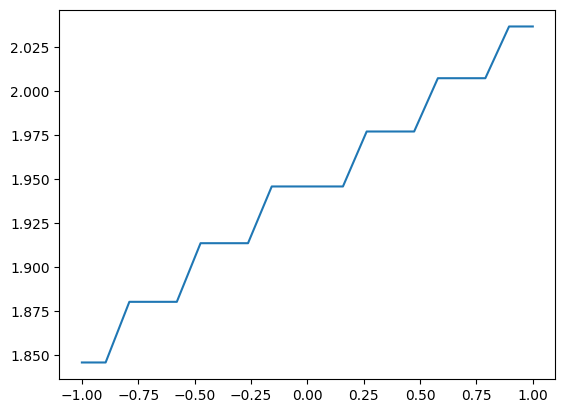

In [23]:
along_y_series = along_y.to_GridSeries()
plt.plot(along_y_series)

## Masks

It is often useful to mask the data according to some criterion. For example, mask the atmosphere out in a GRMHD simulation. `kuibit` fully supports mask with an interface that is similar to the one implemented in `NumPy` (but some features will not work with masked data, for example interpolation). 

The module `kuibit.masks` provides methods to apply masked functions in case the domain is restricted. For example, for the logarithm, or arcsin:

In [24]:
import kuibit.masks as km

arcsin_funk = km.arcsin(more_funk)

print(arcsin_funk.is_masked())

True


Alternatively, it is possible to apply masks according to the value of the data. For instance, masking all the values smaller than a given one:

In [25]:
print(more_funk.abs_min())

funk_masked = more_funk.masked_less(1)

print(funk_masked.abs_min())  # The minimum now reflects the mask

0.6931471805599453
1.0116009116784799


You can extract the mask and apply to another grid variable with the same structure. (This is how you would apply the atmospheric mask to other grid functions). 

In [26]:
funk2 = more_funk ** 2

funk2_masked = funk2.mask_applied(funk_masked.mask)

print(funk2_masked.is_masked())

True


## `visualize_matplotlib`

In this tutorial we plotted all the quantities directly accessing the data. This is a pedagogical choice: you need to know how things work to be able to take full advantage of `kuibit`. However, most often the methods in the module `visualize_matplotlib` will be enough.

The main functions to plot 2D data are: `plot_color` and `plot_contourf`. These take all sorts of inputs, and you should read the documentation. For example, we can plot a `UniformGridData` (the function will behave similarly with `HierarchicalGridData` or NumPy arrays).

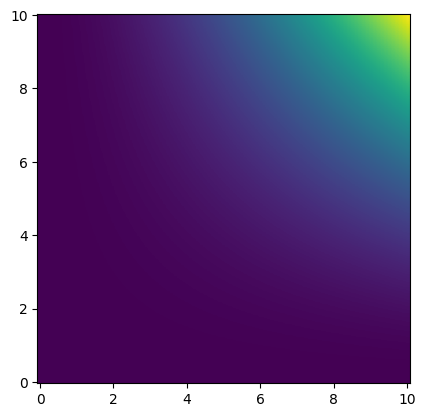

In [27]:
import kuibit.visualize_matplotlib as viz

viz.plot_color(funky_data)

If we are only interested in a smaller region (and setting other parameters):

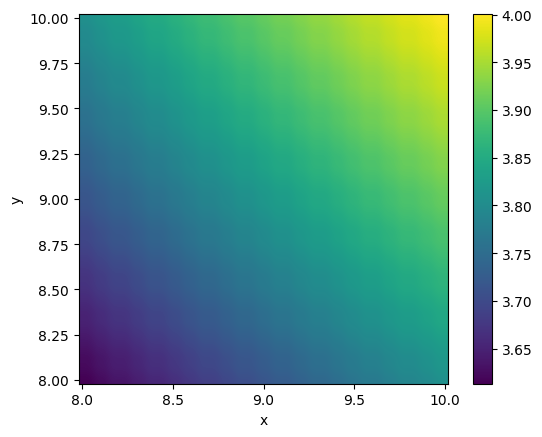

In [28]:
viz.plot_color(funky_data, x0=[8,8], x1=[10,10], 
               shape=[50, 50], colorbar=True, 
               logscale=True, xlabel="x", ylabel="y",
               interpolation="bicubic")

The method `plot_contourf` works in the same way.

If the data has some symmetries (e.g., reflection or rotation), those can be undone to improve the image. To do so, use the `reflection_symmetry_undo` or `rotation180_symmetry_undo` methods.